In [1]:
# -*- coding: utf-8 -*-
"""
Seminárna práca: Klasifikácia sentimentu pomocou Keras a TensorFlow
Autori: Oliver Slivka, Viliam Ráčay VŠE Praha
"""

'\nSeminárna práca: Klasifikácia sentimentu pomocou Keras a TensorFlow\nAutori: Oliver Slivka, Viliam Ráčay VŠE Praha\n'

In [2]:
import os
import warnings
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ['TF_CPP_MIN_VLOG_LEVEL'] = '3'
warnings.filterwarnings(
    "ignore",
    message="Argument `input_shape` is deprecated.*",
    category=UserWarning
)

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import InputLayer
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

E0000 00:00:1747857718.167111 2789024 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747857718.176843 2789024 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# 1. Načítanie datasetu Yelp
yelp = pd.read_csv('yelp_labelled.csv', names=['text', 'label'], sep='\t')

# Zobrazenie hlavičky datasetu
print("\n=== Hlavička datasetu ===")
print(yelp.head())
texts = yelp['text'].values
labels = yelp['label'].values


=== Hlavička datasetu ===
                                                text  label
0                           Wow... Loved this place.      1
1                                 Crust is not good.      0
2          Not tasty and the texture was just nasty.      0
3  Stopped by during the late May bank holiday of...      1
4  The selection on the menu was great and so wer...      1


In [4]:
# 2. Rozdelenie dát 
texts_temp, texts_test, labels_temp, labels_test = train_test_split(
    texts, labels, test_size=0.2, random_state=42)
texts_train, texts_val, labels_train, labels_val = train_test_split(
    texts_temp, labels_temp, test_size=0.25, random_state=42)

print(f"Tréning: {len(texts_train)} príkladov, Validácia: {len(texts_val)}, Test: {len(texts_test)}")

Tréning: 600 príkladov, Validácia: 200, Test: 200


In [12]:
# 3. Predspracovanie 
# Inicializácia vectorizéra s ignorovaním čísel
vectorizer = TfidfVectorizer(
    max_features=2000,
    token_pattern=r'\b[a-zA-Z]+\b'  # Ignoruje čisto numerické tokeny
)
vectorizer.fit(texts_train)

# Transformácia všetkých množín dát
X_train = vectorizer.transform(texts_train).toarray()
X_val = vectorizer.transform(texts_val).toarray()
X_test = vectorizer.transform(texts_test).toarray()

# Priradenie labelov
y_train = labels_train
y_val = labels_val
y_test = labels_test

# Zobrazenie relevantných TF-IDF hodnôt pre ukážkový text
print("\n=== Ukážka predspracovaných dát ===")

# Nájdenie nenulových hodnôt v príklade
sample_idx = 0
nonzero_indices = X_train[sample_idx].nonzero()[0]
nonzero_values = X_train[sample_idx][nonzero_indices]
feature_names = vectorizer.get_feature_names_out()

# Výber 10 najväčších hodnôt
top_indices = np.argsort(nonzero_values)[-10:][::-1]

print("\nPôvodný text:", texts_train[sample_idx])
print("Príslušný label:", labels_train[sample_idx])
print("\nRelevantné TF-IDF hodnoty:")
for idx in top_indices:
    print(f"{feature_names[nonzero_indices[idx]]}: {nonzero_values[idx]:.4f}")

# Vizualizácia ako DataFrame
df_tfidf = pd.DataFrame({
    'Slovo': feature_names[nonzero_indices][top_indices],
    'Hodnota': nonzero_values[top_indices]
})
print("\nTop TF-IDF hodnoty:")
print(df_tfidf.head(10))


=== Ukážka predspracovaných dát ===

Pôvodný text: I've had better bagels from the grocery store.
Príslušný label: 0

Relevantné TF-IDF hodnoty:
store: 0.4505
grocery: 0.4505
bagels: 0.4233
better: 0.3360
ve: 0.3301
from: 0.3152
had: 0.2370
i: 0.1516
the: 0.1205

Top TF-IDF hodnoty:
     Slovo   Hodnota
0    store  0.450529
1  grocery  0.450529
2   bagels  0.423286
3   better  0.335989
4       ve  0.330143
5     from  0.315151
6      had  0.237000
7        i  0.151640
8      the  0.120455


In [6]:
# 4. Funkcia na vytvorenie modelu
def vytvor_model(pocet_vrstiev=1, velkost_skrytej=64, aktivacia='relu', optimizer='adam'):
    model = Sequential()
    model.add(InputLayer(shape=(X_train.shape[1],)))
    model.add(layers.Dense(velkost_skrytej, activation=aktivacia))
    for _ in range(pocet_vrstiev - 1):
        model.add(layers.Dense(velkost_skrytej, activation=aktivacia))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(
        loss='binary_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']
    )
    return model

In [7]:
# 5. Experiment 1
print("\n=== Experiment 1: 1 skrytá vrstva (ReLU + Adam) ===")
model1 = vytvor_model(pocet_vrstiev=1, velkost_skrytej=64, aktivacia='relu', optimizer='adam')
hist1 = model1.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1
)


--- Experiment 1: 1 skrytá vrstva (ReLU + Adam) ---
Epoch 1/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5724 - loss: 0.6893 - val_accuracy: 0.6950 - val_loss: 0.6823
Epoch 2/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8281 - loss: 0.6672 - val_accuracy: 0.7300 - val_loss: 0.6690
Epoch 3/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8770 - loss: 0.6370 - val_accuracy: 0.7650 - val_loss: 0.6482
Epoch 4/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9386 - loss: 0.5933 - val_accuracy: 0.7800 - val_loss: 0.6206
Epoch 5/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9477 - loss: 0.5336 - val_accuracy: 0.7750 - val_loss: 0.5891
Epoch 6/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9443 - loss: 0.4644 - val_accuracy: 0.7750 - val_loss: 0.5574
Epoch 7/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9720 - loss: 0.3894 - val_accuracy: 0.7900 - val_loss: 0.5308
Epoch 8/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.

In [8]:
# 6. Experiment 2 
print("\n=== Experiment 2: 3 skryté vrstvy (tanh + RMSprop) ===")
model2 = vytvor_model(pocet_vrstiev=3, velkost_skrytej=32, aktivacia='tanh', optimizer='rmsprop')
hist2 = model2.fit(
    X_train, y_train,
    epochs=40,
    batch_size=64,
    validation_data=(X_val, y_val),
    verbose=1
)


--- Experiment 2: 3 skryté vrstvy (tanh + RMSprop) ---
Epoch 1/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.5392 - loss: 0.6893 - val_accuracy: 0.6750 - val_loss: 0.6723
Epoch 2/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7902 - loss: 0.6552 - val_accuracy: 0.7250 - val_loss: 0.6402
Epoch 3/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8466 - loss: 0.5912 - val_accuracy: 0.7450 - val_loss: 0.5894
Epoch 4/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8820 - loss: 0.4939 - val_accuracy: 0.7550 - val_loss: 0.5378
Epoch 5/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9329 - loss: 0.3756 - val_accuracy: 0.7750 - val_loss: 0.4981
Epoch 6/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9446 - loss: 0.2665 - val_accuracy: 0.7900 - val_loss: 0.4694
Epoch 7/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9642 - loss: 0.1888 - val_accuracy: 0.7700 - val_loss: 0.4568
Epoch 8/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - ac

In [9]:
# 7. Experiment 3
print("\n=== Experiment 3: 2 vrstvy (ReLU + SGD s LR decay) ===")

# Definícia learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.1,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True
)

model3 = Sequential([
    InputLayer(shape=(X_train.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model3.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9),
    metrics=['accuracy']
)

hist3 = model3.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    validation_data=(X_val, y_val),
    verbose=1
)


--- Experiment 3: 2 vrstvy (ReLU + SGD s LR decay) ---
Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5135 - loss: 0.6940 - val_accuracy: 0.5050 - val_loss: 0.6894
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5617 - loss: 0.6842 - val_accuracy: 0.6150 - val_loss: 0.6585
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6455 - loss: 0.6192 - val_accuracy: 0.7550 - val_loss: 0.5211
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8260 - loss: 0.3819 - val_accuracy: 0.7900 - val_loss: 0.5042
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8936 - loss: 0.2206 - val_accuracy: 0.7050 - val_loss: 0.7262
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9801 - loss: 0.0748 - val_accuracy: 0.7400 - val_loss: 0.7538
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9851 - loss: 0.0315 - val_accuracy: 0.7350 - val_loss: 0.8762
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy:

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


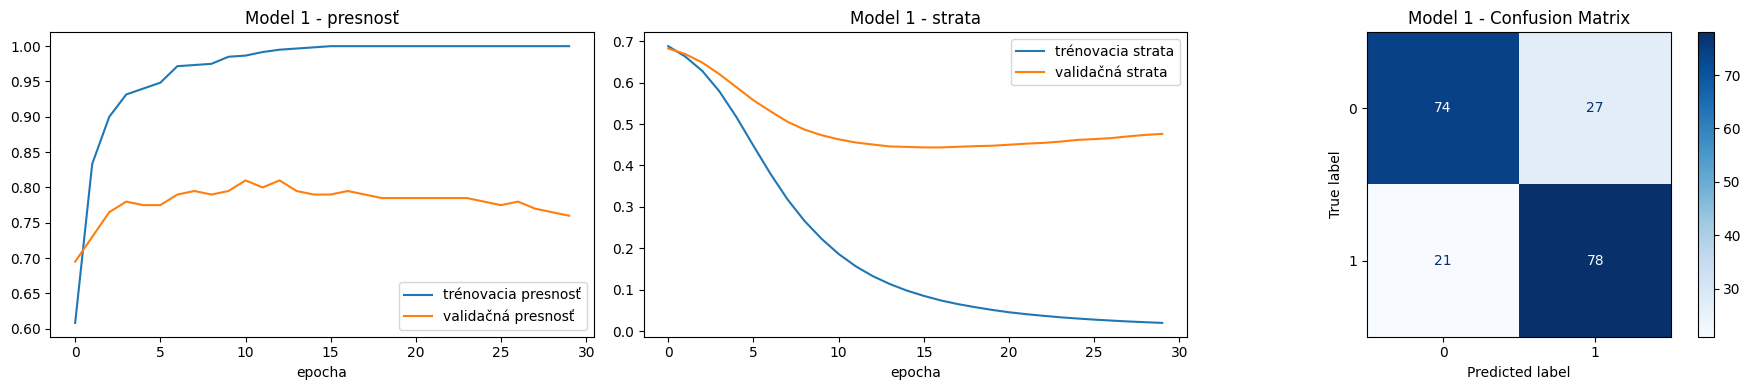

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


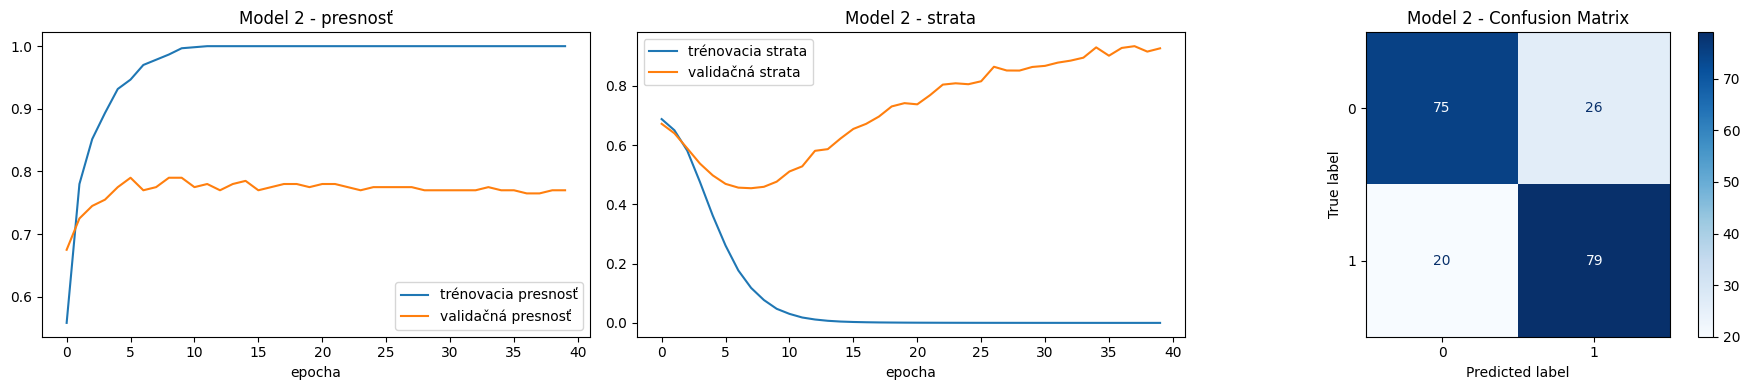

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


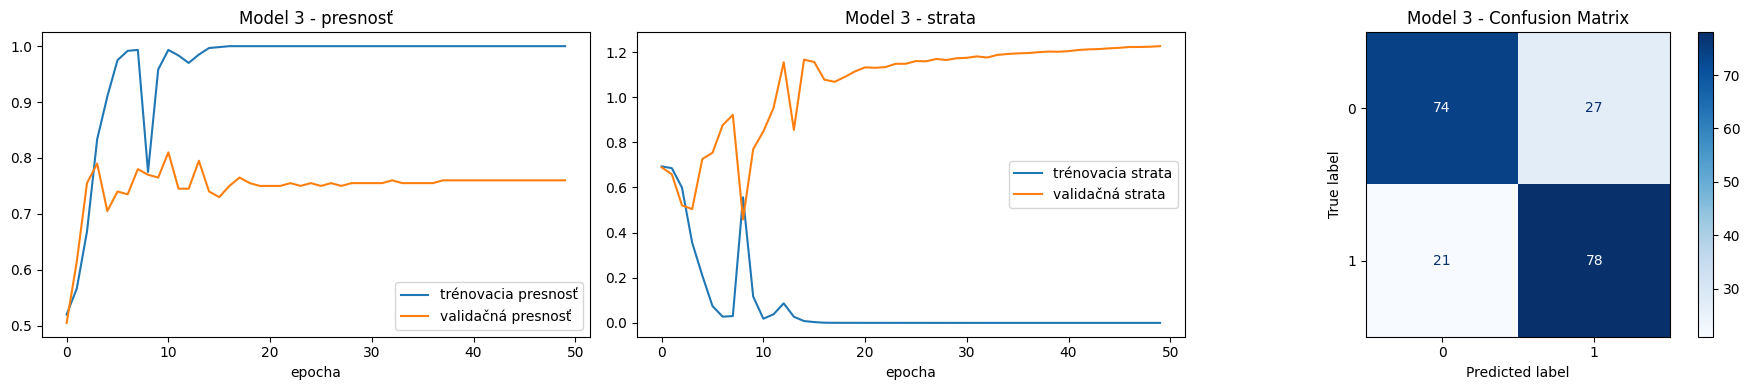

In [10]:
# 8. Vizualizácia s confusion matrix
def vykresli_hist(historia, nazov, model, X_val, y_val):
    plt.figure(figsize=(18,4))
    
    # subplot pre presnost
    plt.subplot(1,3,1)
    plt.plot(historia.history['accuracy'], label='trénovacia presnosť')
    plt.plot(historia.history['val_accuracy'], label='validačná presnosť')
    plt.title(f'{nazov} - presnosť')
    plt.xlabel('epocha')
    plt.legend()

    # subplot pre stratu
    plt.subplot(1,3,2)
    plt.plot(historia.history['loss'], label='trénovacia strata')
    plt.plot(historia.history['val_loss'], label='validačná strata')
    plt.title(f'{nazov} - strata')
    plt.xlabel('epocha')
    plt.legend()

    # subplot pre confusion matrix
    plt.subplot(1,3,3)
    pred_val = (model.predict(X_val) > 0.5).astype("int32")
    cm = confusion_matrix(y_val, pred_val)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=plt.gca(), cmap='Blues')
    plt.title(f'{nazov} - Confusion Matrix')

    plt.tight_layout()
    plt.show()

# Zavolanie vizualizacie pre vsetky modely
vykresli_hist(hist1, 'Model 1', model1, X_val, y_val)
vykresli_hist(hist2, 'Model 2', model2, X_val, y_val)
vykresli_hist(hist3, 'Model 3', model3, X_val, y_val)


In [13]:
# 9. Evaluácia
def vyhodnot(model, X, y, nazov, cost_matrix=None):
    # vyhodnotenie presnosti a straty
    loss, acc = model.evaluate(X, y, verbose=0)
    print(f"{nazov}: presnosť {acc:.4f}, strata {loss:.4f}")
    # ak mame cost_matrix, vypocitaj cenu
    if cost_matrix is not None:
        # ziskaj predikcie a confusion matrix
        y_pred = (model.predict(X) > 0.5).astype(int)
        cm = confusion_matrix(y, y_pred)
        # cena je sucet cm * cost_matrix
        cost = np.sum(cm * cost_matrix)
        print(f"{nazov}: cena modelu {cost}")

# definicia cost_matrix
# riadky = pravda [neg, pos], stlpce = predikovane [neg, pos]
# napr [ [0, C_FN], [C_FP, 0] ]
cost_matrix = np.array([
    [  0, 10],  # false negative stoji 10
    [  1,  0]   # false positive stoji 1
])

print("\n--- Vyhodnotenie modelov na teste ---")
vyhodnot(model1, X_test, y_test, 'Model 1', cost_matrix)
vyhodnot(model2, X_test, y_test, 'Model 2', cost_matrix)
vyhodnot(model3, X_test, y_test, 'Model 3', cost_matrix)


--- Vyhodnotenie modelov na teste ---
Model 1: presnosť 0.8000, strata 0.4914
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Model 1: cena modelu 166
Model 2: presnosť 0.8000, strata 1.0000
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Model 2: cena modelu 166
Model 3: presnosť 0.7750, strata 1.2914
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Model 3: cena modelu 189
